# DATA PREPARATION

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup, NavigableString
from urllib import request
import re
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from scipy.stats import levene
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings("error")

In [2]:
#urls

directives = [
    {
        'url': 'http://www.cherryblossom.org/results/1999/cb99f.html',
        'fields': ['TIME']
    },
    {
        'url': 'http://www.cherryblossom.org/results/2000/Cb003f.htm',
        'fields': ['Net Tim']
    },
    {
        'url': 'http://www.cherryblossom.org/results/2001/oof_f.html',
        'fields': ['NET']
    },   
    {
        'url': 'http://www.cherryblossom.org/results/2002/ooff.htm',
        'fields': ['Net']
    }, 
    {
        'url': 'http://www.cherryblossom.org/results/2003/CB03-F.HTM',
        'fields': ['Net Tim']
    },   
    {
        'url': 'http://www.cherryblossom.org/results/2004/women.htm',
        'fields': ['Net']
    },    
    {
        'url': 'http://www.cherryblossom.org/results/2005/CB05-F.htm',
        'fields': ['Net']
    },  
    {
        'url': 'http://www.cherryblossom.org/results/2006/women.htm',
        'fields': ['Net Tim']
    },    
    {
        'url': 'http://www.cherryblossom.org/results/2007/women.htm',
        'fields': ['Time']
    },
    {
        'url': 'http://www.cherryblossom.org/results/2008/women.htm',
        'fields': ['Time']
    },
    {
        'url': 'http://www.cherryblossom.org/results/2009/09cucb-F.htm',
        'fields': ['Net Tim']
    },      
    {
        'url': 'http://www.cherryblossom.org/results/2010/2010cucb10m-f.htm',
        'fields': ['Net Tim']
    },    
    {
        'url': 'http://www.cherryblossom.org/results/2011/2011cucb10m-f.htm',
        'fields': ['Net Tim']
    },    
    {
        'url': 'http://www.cherryblossom.org/results/2012/2012cucb10m-f.htm',
        'fields': ['Time']
    },
  
]

In [3]:
common_fields = ['PLACE', 'NAME', 'AG', 'HOMETOWN']

In [4]:
def nested_search(tag):
    for c in tag.children:
        if isinstance(c, NavigableString):
            return c
        else:
            return nested_search(c)

In [5]:
def pull_data(url):
    req = request.urlopen(url)
    content = req.read()
    
    page = BeautifulSoup(content, 'lxml')
    #table = page.find('pre')
    #nested_search(table)
    contents = page.find(text=re.compile('(PLACE)|(Place)'))
    #print(contents)
    raw_lines = contents.split('\n')
    
    dem_index = 0
    for idx, line in enumerate(raw_lines):
        if line.startswith('===='):
            dem_index = idx
            break
    
    if dem_index > 0:
        raw_lines = [line for line in raw_lines[dem_index-1:] if line != '']
    
    return raw_lines

In [6]:
def extract_values(line, end_indices):
    values = []
    for i in range( len(end_indices) ):
        if i == 0:
            start = 0
        else:
            start = end_indices[i-1]
            
        end = end_indices[i]
        value = line[start:end]
        
        value = value.strip()
        values.append(value)
        
    return values

In [7]:
def extract_data(lines):
    # Extract the demarcator line
    dem = lines[1].split()
    
    if len(dem) < 1:
        return pd.DataFrame(lines)
    
    # Get the field end indices
    dem_lens = [len(d)+1 for d in dem]
    end_indices = np.cumsum(dem_lens).tolist()
    
    # Extract the fields headers
    headers = extract_values(lines[0], end_indices)
    
    data = []
    for line in lines[2:]:
        values = extract_values(line, end_indices)
        data.append(values)
    
    df = pd.DataFrame(data, columns=headers)
    
    return df

In [8]:
tables = []

for d in directives:
    raw_lines = pull_data(d['url'])
    df = extract_data(raw_lines)
    
    # Form the select columns
    select_cols = common_fields + d['fields']
    select_cols = [c.lower() for c in select_cols]
    
    df.columns = [str(c).lower() for c in df.columns]
    
    if all([c in df.columns 
            for c in select_cols]):
        df = df[select_cols]
    
    tables.append(df)

In [9]:
#Create Data Frame 1999
df_0 = tables[0]
df_0['year'] = 1999
df_0 = df_0.astype(str)

#Create Data Frame 2000
df_1 = tables[1]
df_1['year'] = 2000
df_1.rename(columns={'net tim': 'time'},inplace=True)
df_1 = df_1.astype(str)
df_1 = df_1[:-1]

#Create Data Frame 2001
#This one is all stupid
df_2 = tables[2]
df_2 = df_2.iloc[3:]
df_2.rename(columns={'0': 'COL_NAME'},inplace=True)
df_2['COL_NAME'] = df_2['COL_NAME'].str.replace(r'#', '')
df_2['COL_NAME'] = df_2['COL_NAME'].str.replace(r'*', '')
df_2 = df_2[:-1]

place = pd.DataFrame(df_2['COL_NAME'].str[:5])
place.rename(columns={'COL_NAME': 'place'},inplace=True)

name = pd.DataFrame(df_2['COL_NAME'].str[12:34])
name.rename(columns={'COL_NAME': 'name'},inplace=True)

ag = pd.DataFrame(df_2['COL_NAME'].str[34:37])
ag.rename(columns={'COL_NAME': 'ag'},inplace=True)

hometown = pd.DataFrame(df_2['COL_NAME'].str[37:56])
hometown.rename(columns={'COL_NAME': 'hometown'},inplace=True)

time = pd.DataFrame(df_2['COL_NAME'].str[56:63])
time.rename(columns={'COL_NAME': 'time'},inplace=True)

df_2 = place.join(name)
df_2 = df_2.join(ag)
df_2 = df_2.join(hometown)
df_2 = df_2.join(time)
df_2['year'] = 2001
df_2 = df_2.astype(str)


#Create Data Frame 2002
df_3 = tables[3]
df_3['year'] = 2002
df_3.rename(columns={'net': 'time'},inplace=True)
df_3 = df_3.astype(str)
df_3 = df_3[:-1]

#Create Data Frame 2003
df_4 = tables[4]
df_4.drop([ 'div /tot', 'num', 'gun tim'], axis=1, inplace=True)
df_4['year'] = 2003
df_4.rename(columns={'net ti': 'time'},inplace=True)
df_4 = df_4.astype(str)
df_4 = df_4[:-2]

#Create Data Frame 2004
df_5 = tables[5]
df_5['year'] = 2004
df_5.rename(columns={'net': 'time'},inplace=True)
df_5 = df_5.astype(str)

#Create Data Frame 2005
df_6 = tables[6]
df_6['year'] = 2005
df_6.rename(columns={'net': 'time'},inplace=True)
df_6 = df_6.astype(str)
df_6 = df_6[:-1]

#Create Data Frame 2006
df_7a = tables[7]
df_7 = df_7a[['place', 'name', 'ag', 'hometown        net tim']].copy()
home_time =  df_7['hometown        net tim'].str.split(' ')
df_7.loc[:, 'hometown'] = home_time.apply(lambda v: ' '.join(v[:-1]).strip() ).values
df_7.loc[:, 'tim'] = home_time.apply(lambda v: v[-1] ).values
df_7.drop('hometown        net tim', axis=1, inplace=True)
df_7.rename(columns={'tim': 'time'},inplace=True)
df_7['year'] = 2006
df_7 = df_7.astype(str)
df_7 = df_7[:-2]

#Create Data Frame 2007
df_8 = tables[8]
df_8['year'] = 2007
df_8 = df_8.astype(str)
df_8 = df_8[:-2]

#Create Data Frame 2008
df_9 = tables[9]
df_9['year'] = 2008
df_9 = df_9.astype(str)

#Create Data Frame 2009
df_10 = tables[10]
df_10['year'] = 2009
df_10.rename(columns={'net tim': 'time'},inplace=True)
df_10 = df_10.astype(str)
df_10 = df_10[:-2]

#Create Data Frame 2010
df_11 = tables[11]
df_11['year'] = 2010
df_11.rename(columns={'net tim': 'time'},inplace=True)
df_11 = df_11.astype(str)
df_11 = df_11[:-2]

#Create Data Frame 2011
df_12 = tables[12]
df_12['year'] = 2011
df_12.rename(columns={'net tim': 'time'},inplace=True)
df_12 = df_12.astype(str)

#Create Data Frame 2012
df_13 = tables[13]
df_13['year'] = 2012
df_13 = df_13.astype(str)

C:\Users\javie\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\javie\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\javie\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [10]:
#merge all data frames
df_complete = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5
                         ,df_6, df_7, df_8, df_9, df_10
                         ,df_11, df_12, df_13
                        ])

#Remove special characters / renames ag to age / stipes all white spaces
df_complete['time'] = df_complete['time'].str.replace(r'#', '')
df_complete['time'] = df_complete['time'].str.replace(r'*', '')
df_complete['ag'] = df_complete['ag'].str.replace(r'XX', '')
df_complete.rename(columns={'ag': 'age'},inplace=True)
df_complete = df_complete.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

print("Row Count: ", df_complete.shape[0])
print("Columns Count: ", df_complete.shape[1])
print("")
print("Columns Types")
df_complete.dtypes


Row Count:  76059
Columns Count:  6

Columns Types


place       object
name        object
age         object
hometown    object
time        object
year        object
dtype: object

In [11]:
#Dropping some other none values in the dataframe
df_complete = df_complete[df_complete['age']!='']
df_complete = df_complete[df_complete['age']!=0]
df_complete['age'] = df_complete['age'].astype('int32')

# EDA

In [12]:
df_complete.describe()

,age
count,76038.000000
mean,33.852350
std,9.222845
min,0.000000
25%,27.000000
50%,32.000000
75%,39.000000
max,87.000000


In [13]:
#Different years
df = {}
age = {}
for year in range(1999,2013):
    df[year] = df_complete[df_complete['year']==str(year)]
    age[year] = df[year]['age']

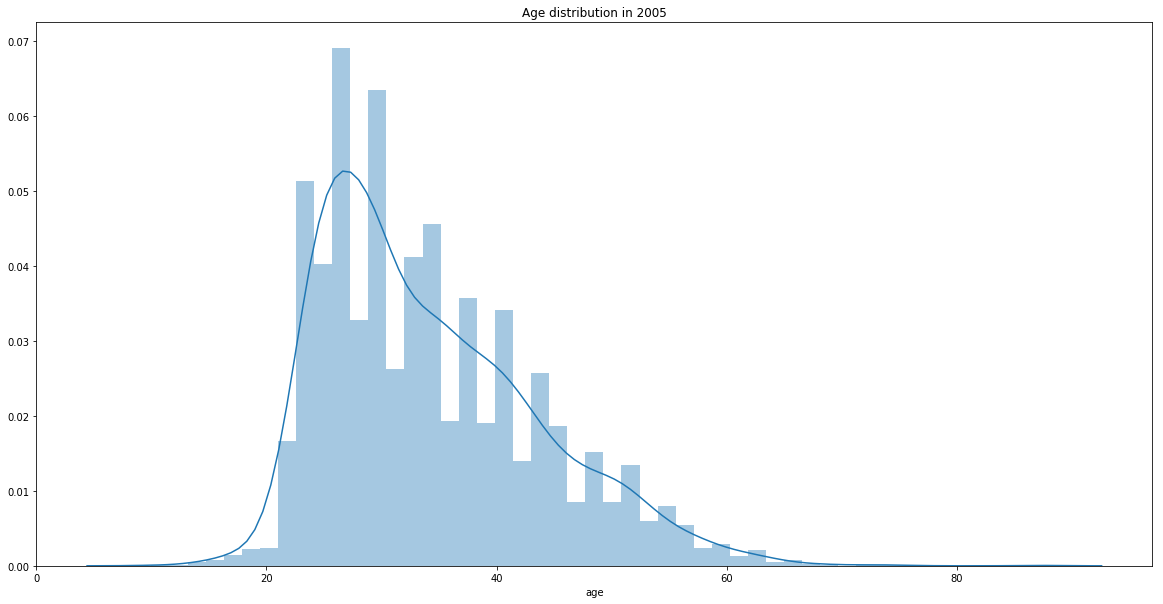

In [14]:
plt.figure(figsize=(20,10))
plt.title('Age distribution in 2005')
sns.distplot(age[2005])

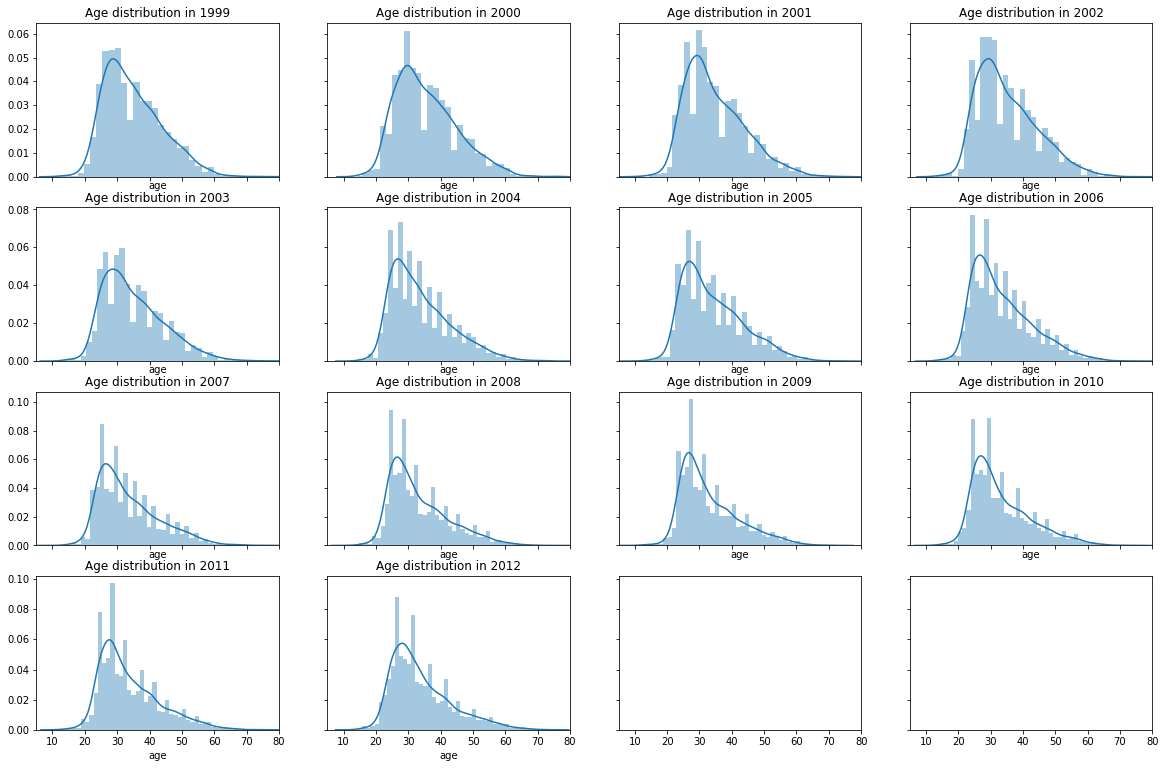

In [15]:
#Density Curve
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(20,13))
for i in range(14):
    year = 1999 + i 
    ax[i//4, i%4].set_title('Age distribution in {}'.format(year))
    ax[i//4, i%4].set_xlim((5,80))
    sns.distplot(age[year], ax=ax[i//4,i%4])
    


Text(0, 0.5, 'Density')

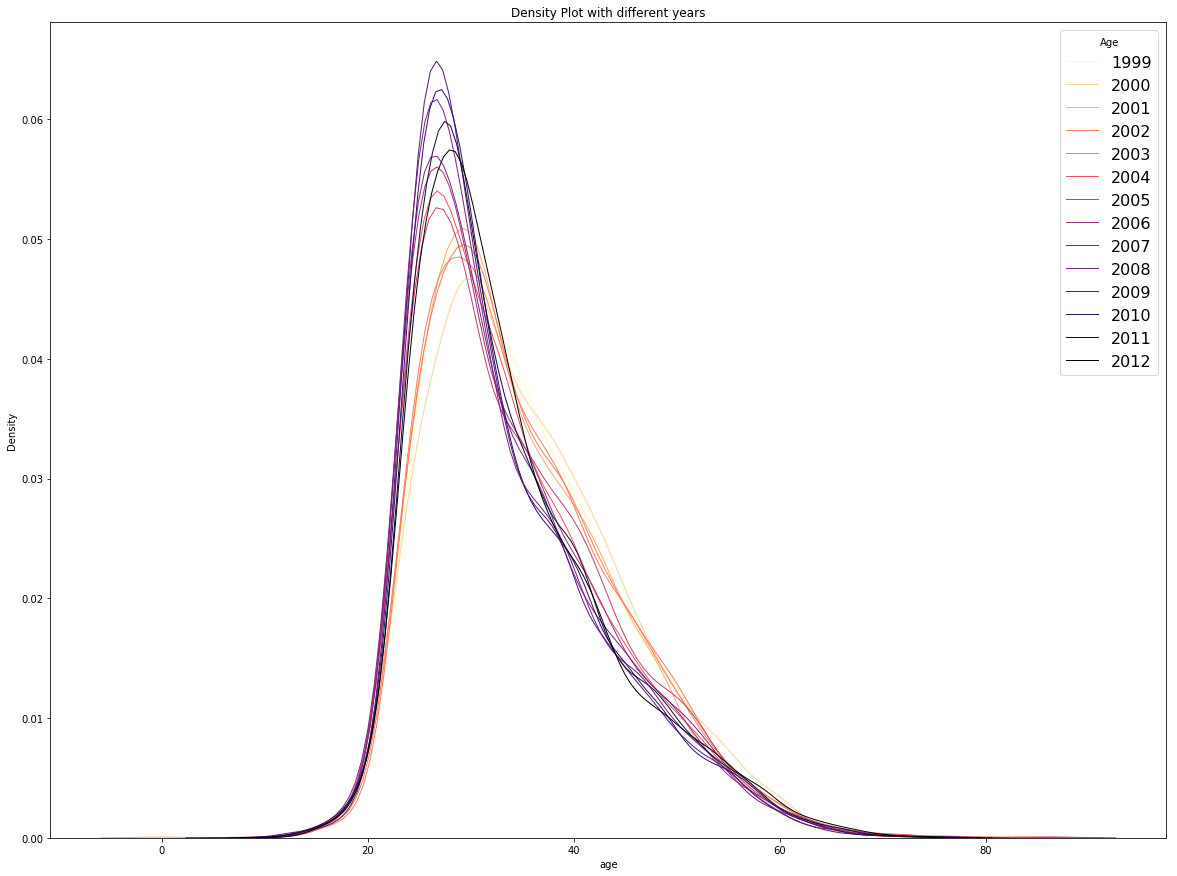

In [16]:
#Density Curve in one plot using color map
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

magma = cm.get_cmap('magma', 12)

plt.figure(figsize=(20,15))
for year in range(1999,2013):
    # Draw the density plot
    alpha = (year-1998)/15
    sns.distplot(age[year], hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = year, color = magma(1-alpha))
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Age')
plt.title('Density Plot with different years')
plt.xlabel('age')
plt.ylabel('Density')

Text(0, 0.5, 'Cumulative Density')

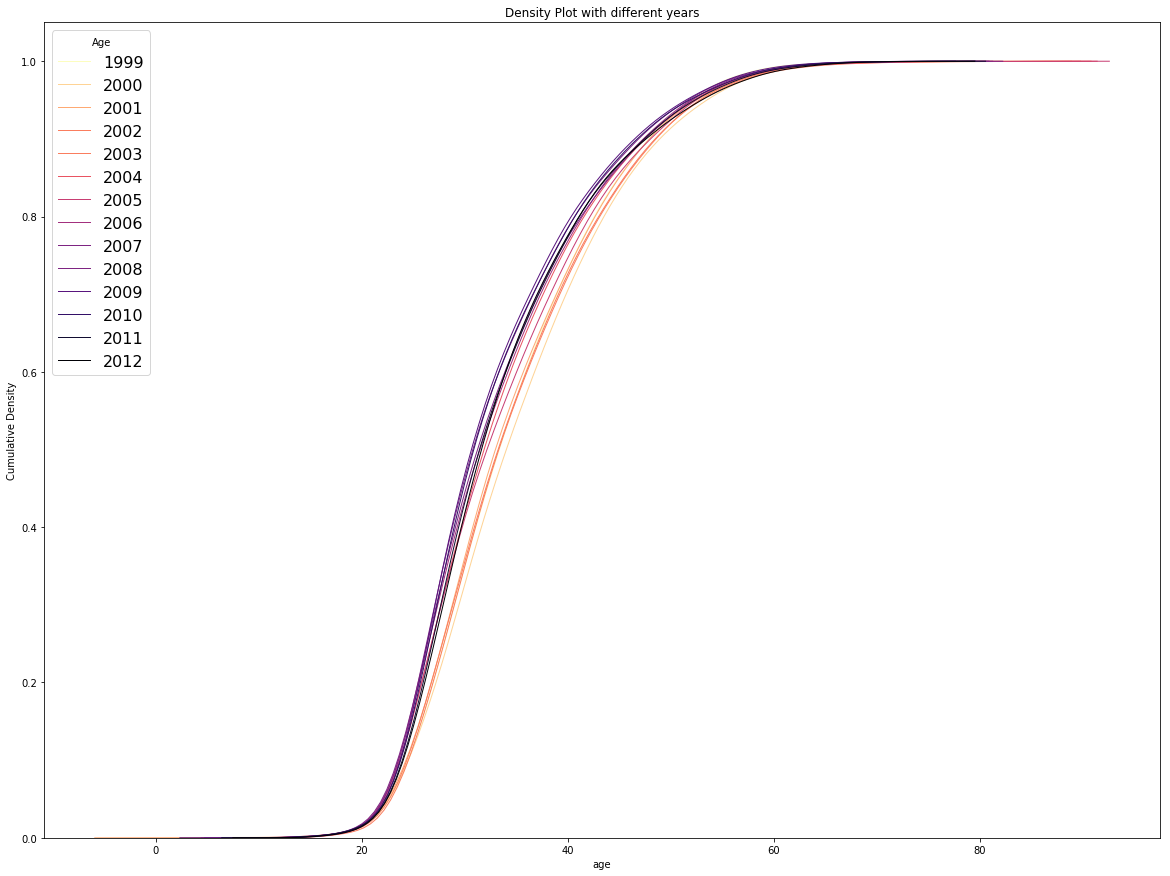

In [17]:
#CDF
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

magma = cm.get_cmap('magma', 12)

plt.figure(figsize=(20,15))
for year in range(1999,2013):
    # Draw the density plot
    alpha = (year-1998)/15
    sns.distplot(age[year], hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'cumulative': True},
                 label = year, color = magma(1-alpha))
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Age')
plt.title('Density Plot with different years')
plt.xlabel('age')
plt.ylabel('Cumulative Density')


In [18]:
#Quantile-Quantile plot.
def qqp(x, y, ax, quantile=None, rug=False,  **kwargs):
    if quantile==None:
        quantiles = min(len(x), len(y))
    quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation='nearest')
    y_quantiles = np.quantile(y, quantiles, interpolation='nearest')
    if rug:
        rug_x_params = dict(ymin=0, ymax=.05, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=.05, c='gray', alpha=0.5)
        #Rug plot
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    #Adding 45 line
    ax.plot([max(ax.get_xlim()[0], ax.get_ylim()[0]), 
         min(ax.get_xlim()[1], ax.get_ylim()[1])],
        [max(ax.get_xlim()[0], ax.get_ylim()[0]), 
         min(ax.get_xlim()[1], ax.get_ylim()[1])])
    #plt.show()
    

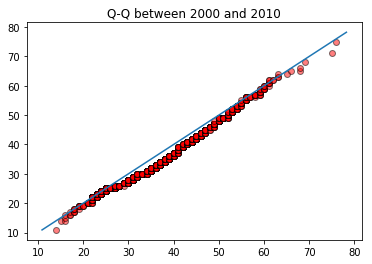

In [19]:
#An example of Q-Q plot
ax = plt.subplot(111, title='Q-Q between 2000 and 2010')
qqp(age[2000], age[2010], ax, c='r', alpha=0.5, edgecolor='k')

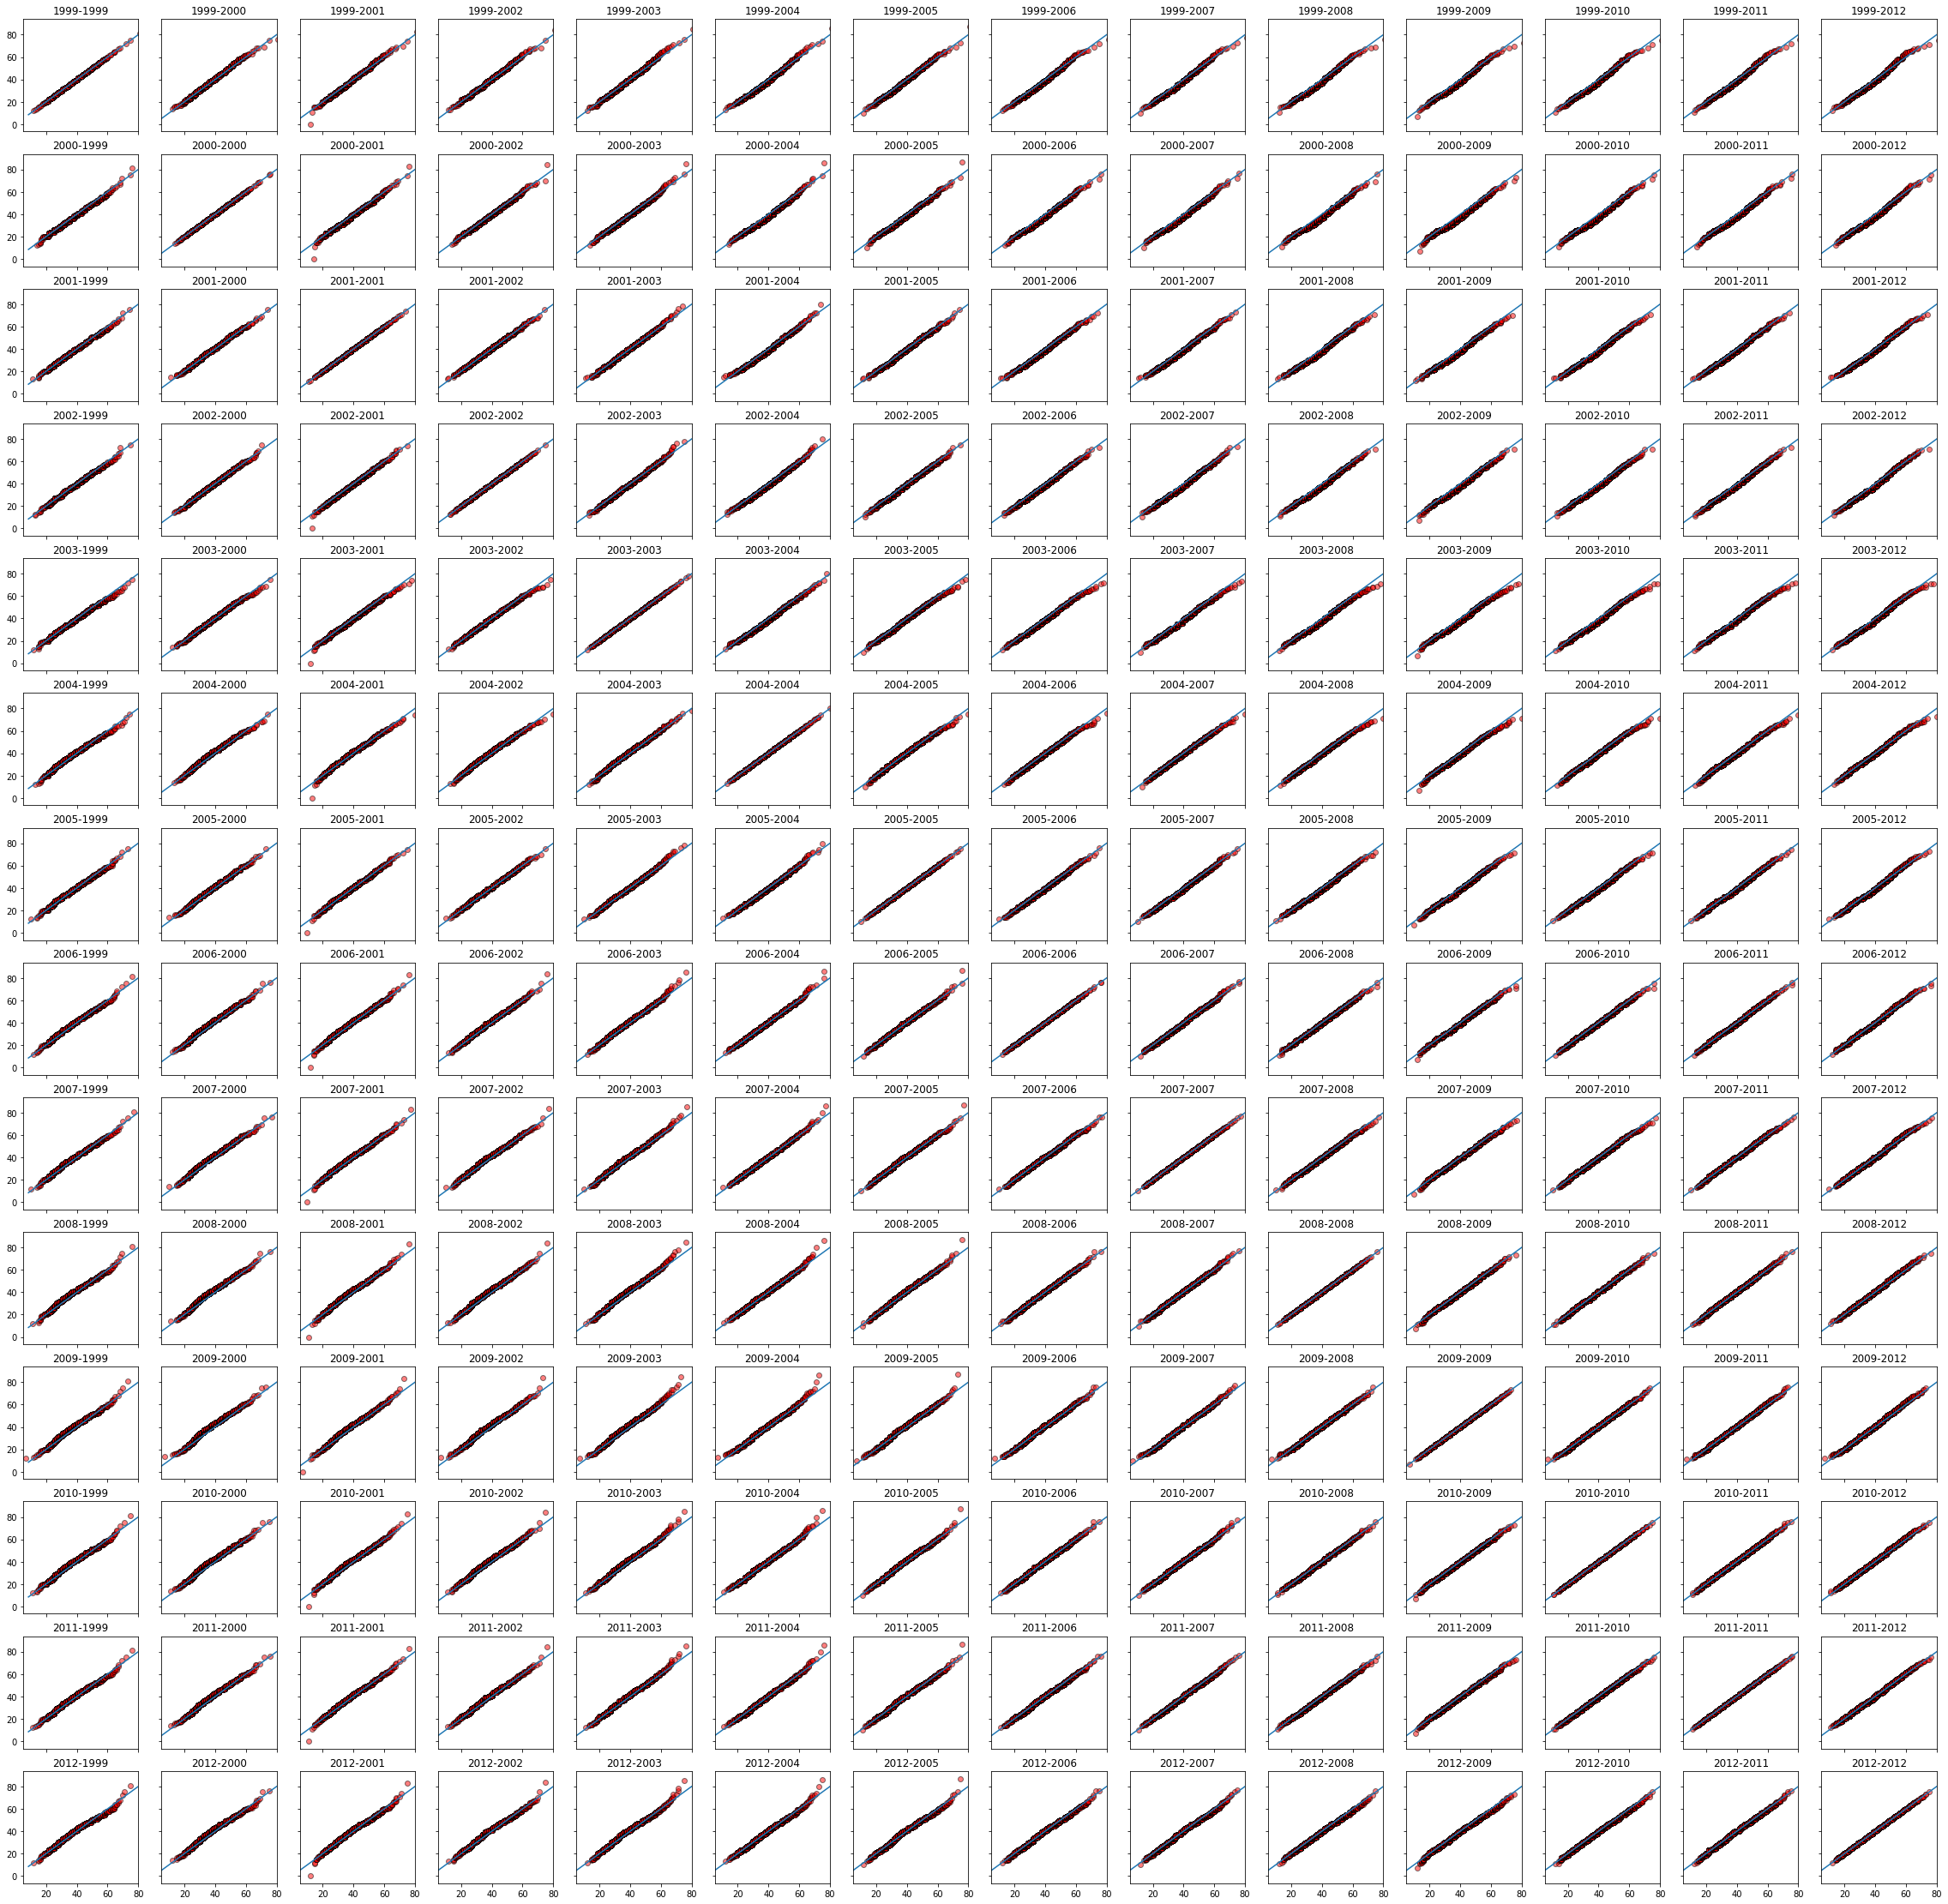

In [20]:
n = 14
fig, ax = plt.subplots(n, n, sharex='col', sharey='row', figsize=(40,40))
for i in range(n):
    for j in range(n):
        y1 = 1999 + i
        y2 = 1999 + j
        ax[i, j].set_title('{}-{}'.format(y1,y2))
        ax[i, j].set_xlim((5,80))
        qqp(age[y1], age[y2], ax[i, j], c='r', alpha=0.5, edgecolor='k')
        

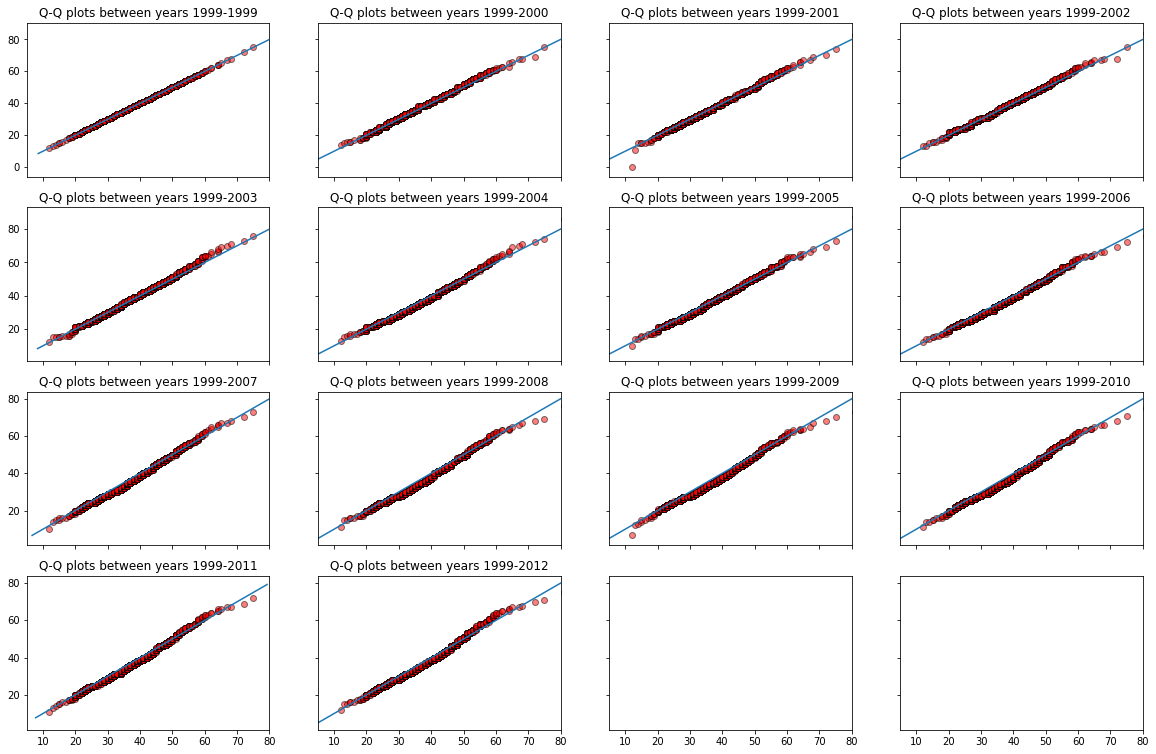

In [21]:
y1 = 1999
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(20,13))
for i in range(14):
    y2 = 1999 + i
    ax[i//4, i%4].set_title('Q-Q plots between years {}-{}'.format(y1,y2))
    ax[i//4, i%4].set_xlim((5,80))
    qqp(age[y1], age[y2], ax[i//4, i%4], c='r', alpha=0.5, edgecolor='k')

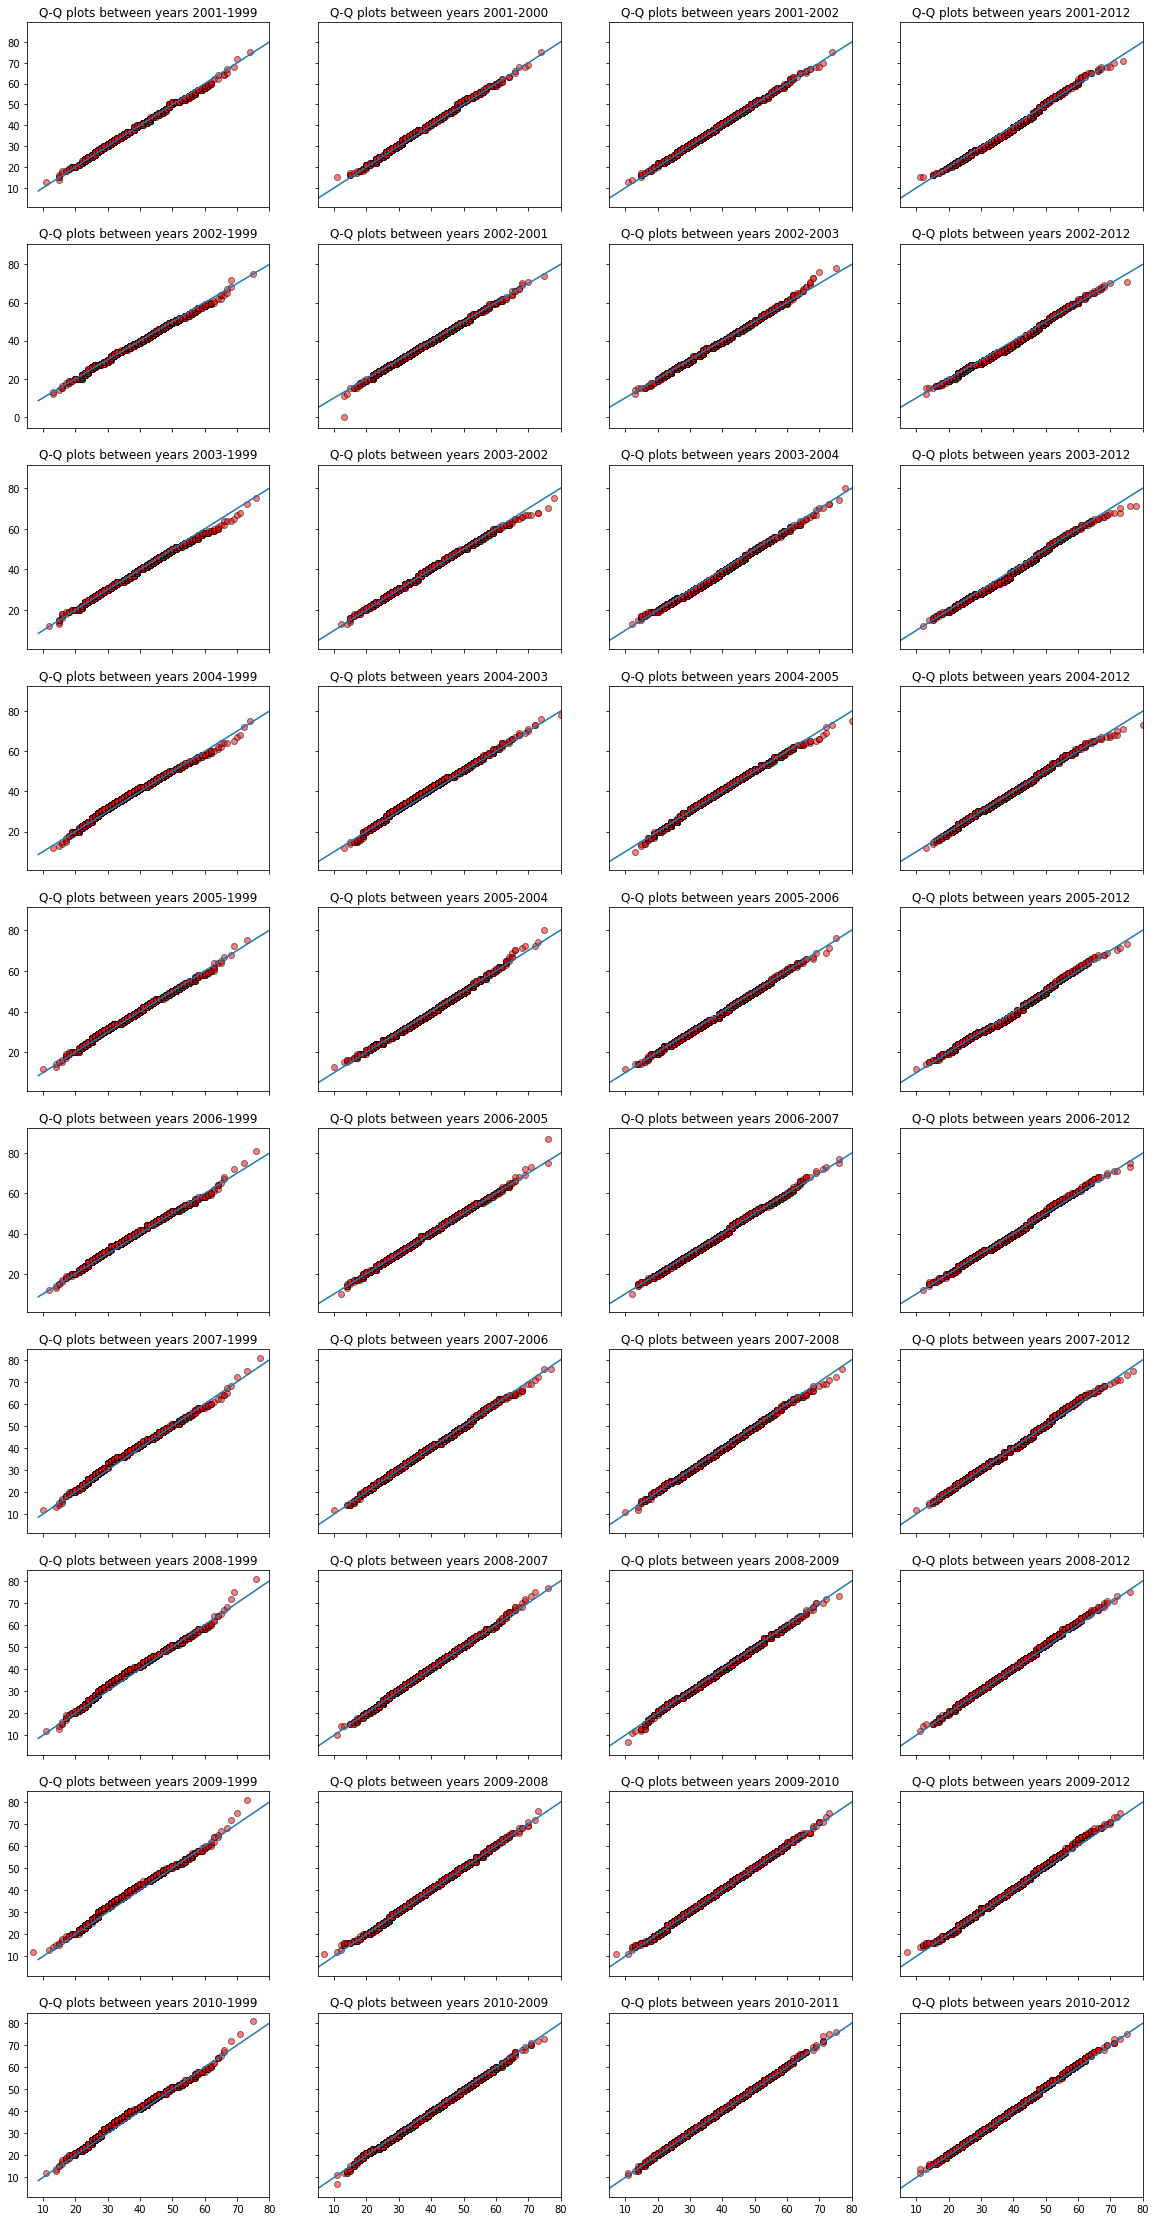

In [22]:
years = []
fig, ax = plt.subplots(10, 4, sharex='col', sharey='row', figsize=(20,40))
for i in range(2,12):
    y = 1999 + i 
    years = [1999, 1999 + i - 1, 1999 + i + 1, 2012]
    for j,year in enumerate(years): 
        ax[i-2, j].set_title('Q-Q plots between years {}-{}'.format(y,year))
        ax[i-2, j].set_xlim((5,80))
        qqp(age[y], age[year], ax[i-2, j], c='r', alpha=0.5, edgecolor='k')
  

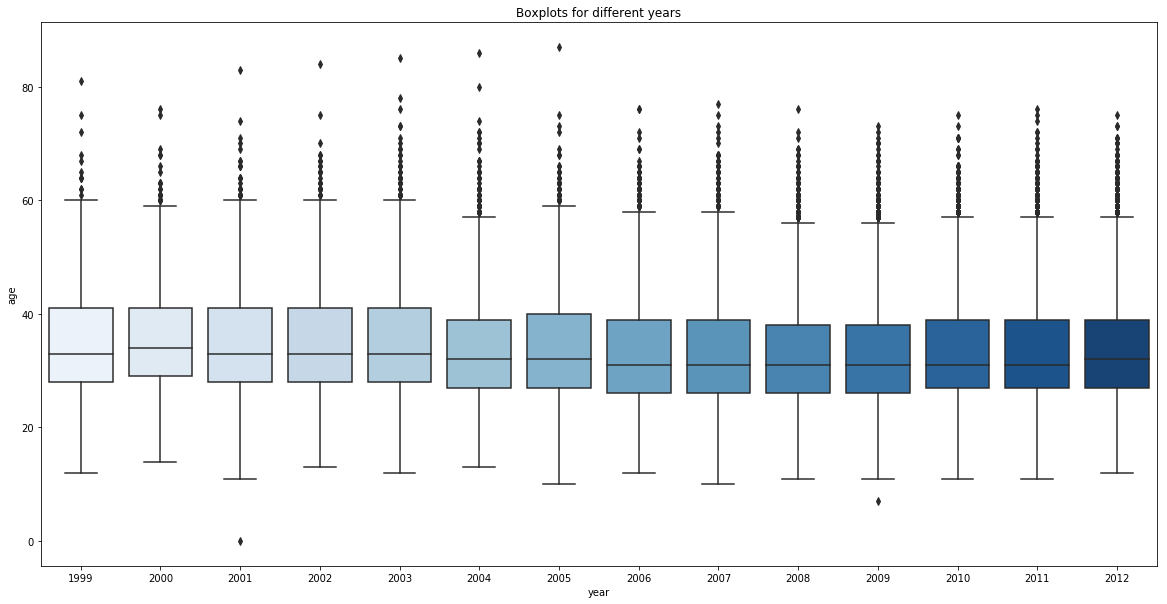

In [23]:
#BOX PLOT
plt.figure(figsize=(20,10))
sns.boxplot( x=df_complete['year'], y=df_complete['age'], palette="Blues")
plt.title('Boxplots for different years')
plt.show()

In [24]:
Q = pd.DataFrame(index=[0.01,0.25,0.5,0.75,0.99,'mean'])
for year in range(1999,2013):
    Q[year] = df[year]['age'].quantile([0.01,0.25,0.5,0.75,0.99])
    Q[year]['mean'] = df[year]['age'].mean()
    

In [25]:
Q

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0.01,20.000000,20.000000,20.000000,21.000000,20.410000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,19.000000,19.290000,20.000000
0.25,28.000000,29.000000,28.000000,28.000000,28.000000,27.000000,27.000000,26.000000,26.000000,26.000000,26.000000,27.000000,27.000000,27.000000
0.5,33.000000,34.000000,33.000000,33.000000,33.000000,32.000000,32.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,32.000000
0.75,41.000000,41.000000,41.000000,41.000000,41.000000,39.000000,40.000000,39.000000,39.000000,38.000000,38.000000,39.000000,39.000000,39.000000
0.99,58.000000,60.000000,60.000000,60.000000,61.000000,60.000000,60.000000,60.000000,59.000000,60.000000,59.000000,59.000000,60.000000,61.000000
mean,34.900935,35.553555,34.806191,35.137838,35.051383,33.932547,34.169249,33.653478,33.521449,33.210255,33.077515,33.297074,33.740199,33.877994


Text(0, 0.5, 'age')

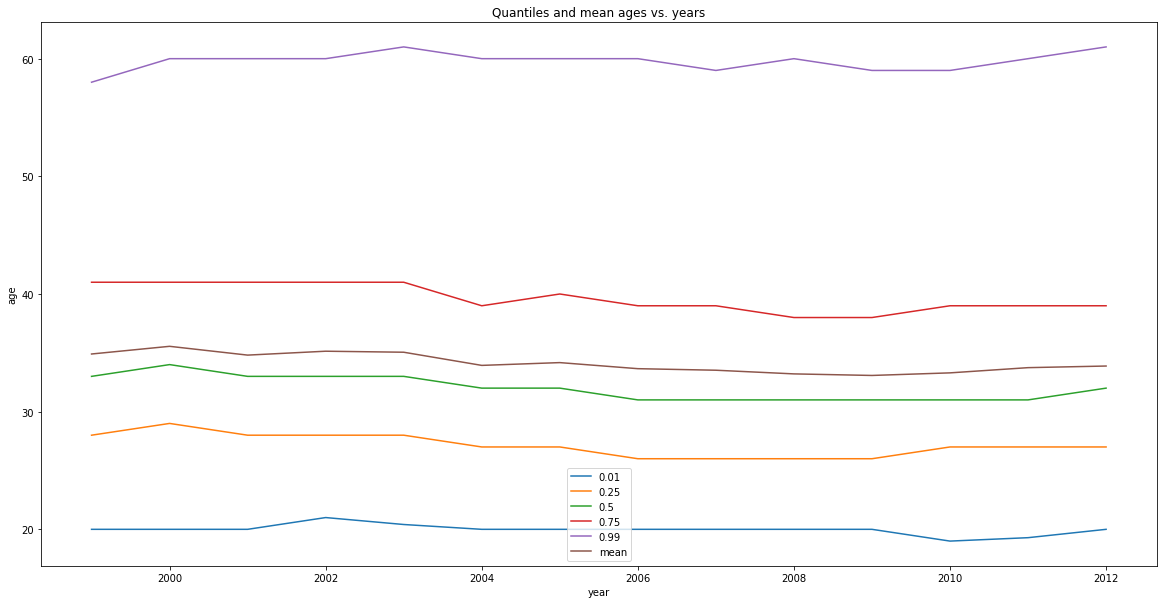

In [26]:
Q.T.plot(figsize=(20,10))
plt.title('Quantiles and mean ages vs. years')
plt.xlabel('year')
plt.ylabel('age')

# Tukey-Kramer Method

In [27]:
# show H_o rejections in red
def color_rejection_red(val):
    color = 'red' if str(val) == 'True' else 'black'
    return 'color: %s' % color

In [28]:
# check number of racers each year
print(df_complete['year'].value_counts())

2012    9729
2011    9030
2010    8853
2009    8321
2008    6397
2007    5688
2006    5434
2005    4325
2004    3899
2003    3542
2002    3330
2001    2972
1999    2352
2000    2166
Name: year, dtype: int64


In [29]:
# create list of age by years for Levene's Test
lst = df_complete.groupby('year')['age'].apply(pd.Series.tolist).tolist()

# calculate p value
statistic, p_value = levene(lst[0], lst[1], lst[2], lst[3], lst[4], lst[5], lst[6], lst[7],
                            lst[8], lst[9], lst[10], lst[11], lst[12], lst[13], center="mean")
p_value

0.00010289522091025149

In [30]:
# racer numbers are different each year, which means a Tueky-Kramer method is appropriate
# to compare the means of the years

# Set up the data for comparison
MultiComp = MultiComparison(df_complete['age'], df_complete['year'])

# store results table
results = MultiComp.tukeyhsd().summary()

# results

In [31]:
#convert simple table to html table
results_html = results.as_html()

# read html table into pandas dataframe
results_df = pd.read_html(results_html, header=0, index_col=0)[0]

# reset the index
results_df.reset_index(inplace=True)

# create pivot table based on means
results_df2 = results_df.pivot(index='group1', columns='group2', values=['meandiff'])

# create pivot table based on results
results_df = results_df.pivot(index='group1', columns='group2', values=['reject'])

# drop second level from columns
results_df.columns = results_df.columns.droplevel()
results_df2.columns = results_df2.columns.droplevel()

# replace nans w/ blanks for visual appeal
results_df = results_df.fillna('')
results_df2 = results_df2.fillna('')

# change H_o rejections to red
results_df = results_df.style.applymap(color_rejection_red)

In [32]:
# show table
results_df

group2,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
group1,,,,,,,,,,,,,
1999,False,False,False,False,True,False,True,True,True,True,True,True,True
2000,,False,False,False,True,True,True,True,True,True,True,True,True
2001,,,False,False,True,False,True,True,True,True,True,True,True
2002,,,,False,True,True,True,True,True,True,True,True,True
2003,,,,,True,True,True,True,True,True,True,True,True
2004,,,,,,False,False,False,True,True,True,False,False
2005,,,,,,,False,True,True,True,True,False,False
2006,,,,,,,,False,False,True,False,False,False
2007,,,,,,,,,False,False,False,False,False


In [33]:
# show table
results_df2

group2,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
group1,,,,,,,,,,,,,
1999,0.6526,-0.0947,0.2369,0.1504,-0.9684,-0.7317,-1.2475,-1.3795,-1.6907,-1.8234,-1.6039,-1.1607,-1.0229
2000,,-0.7474,-0.4157,-0.5022,-1.621,-1.3843,-1.9001,-2.0321,-2.3433,-2.476,-2.2565,-1.8134,-1.6756
2001,,,0.3316,0.2452,-0.8736,-0.6369,-1.1527,-1.2847,-1.5959,-1.7287,-1.5091,-1.066,-0.9282
2002,,,,-0.0865,-1.2053,-0.9686,-1.4844,-1.6164,-1.9276,-2.0603,-1.8408,-1.3976,-1.2598
2003,,,,,-1.1188,-0.8821,-1.3979,-1.5299,-1.8411,-1.9739,-1.7543,-1.3112,-1.1734
2004,,,,,,0.2367,-0.2791,-0.4111,-0.7223,-0.855,-0.6355,-0.1923,-0.0546
2005,,,,,,,-0.5158,-0.6478,-0.959,-1.0917,-0.8722,-0.429,-0.2913
2006,,,,,,,,-0.132,-0.4432,-0.576,-0.3564,0.0867,0.2245
2007,,,,,,,,,-0.3112,-0.4439,-0.2244,0.2188,0.3565
